In [1]:
# Alrighty then! We found that data for a single day doesn't show potential
# for Customer Segmentation. So we start collating and aggregating data for
# one month.

# Check the project workspace.
import os
print("Project Workspace:", os.getcwd())
print()

# Import all necessary packages for the project.
import pandas as pan
import statistics as myStats
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import DBSCAN as sklearnDBSCAN
import seaborn as sb
import glob
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

# Revome scientific notation to expand numbers in the dataset up to the
# second decimal place.
pan.set_option("display.float_format", lambda x: '%.4f' % x)

Project Workspace: D:\UniSA, Mawson Lakes\Semester 3\Customer Analytics in Large Organizations\Assignment 1



In [96]:
# From the "Sale Date" data, we get the day, month and date columns for each transaction.
def fetchMonthAndYearColumns(dataFile):
    dataFile["Day"] = dataFile["Sale_Date"].apply(lambda month: month.split("-")[2])
    dataFile["Month"] = dataFile["Sale_Date"].apply(lambda month: month.split("-")[1])
    dataFile["Year"] = dataFile["Sale_Date"].apply(lambda year: year.split("-")[0])
    dataFile.drop(columns = ["Sale_Date"])
    return dataFile

# Aggregate the data for each month by "UniSA Customer Number" and "Month of Sale"
# to get "No of Trips per day", "No of Purchases" and the "Total Sale Amount Inclusive of GST".
def aggregateYearData(dataFile):
    # Drop all rows with "NA" for "UniSA Customer Number".
    dataFile = dataFile.dropna(subset = ["UniSA_Customer_No"])
    # Ensure that the minimum value for "Quantity Sold" is "1".
    dataFile["Quantity_Sold"][dataFile["Quantity_Sold"] < 1.0] = 1
    # First aggregate over a day.
    dataFile = dataFile.groupby(by = ["Day", "Month", "Year", "UniSA_Receipt_No1", "UniSA_Customer_No"], as_index = False).agg({"Total_Sale_Amount_InclusiveGST": "mean", "Quantity_Sold": "sum"})
    dataFile = dataFile.groupby(by = ["Day", "Month", "Year", "UniSA_Customer_No"], as_index = False).agg({"UniSA_Receipt_No1": "count", "Total_Sale_Amount_InclusiveGST": "sum", "Quantity_Sold": "sum"}).rename(columns = {"UniSA_Receipt_No1": "No_of_Trips", "Total_Sale_Amount_InclusiveGST": "Total_Sale_Amount"})
    print("Size of Dataset:", dataFile.shape)
    # Then aggregate over a month.
    dataFile = dataFile.groupby(by = ["Month", "Year", "UniSA_Customer_No"], as_index = False).agg({"No_of_Trips": "sum", "Total_Sale_Amount": "sum", "Quantity_Sold": "sum"}).rename(columns = {"No_of_Trips": "Monthly_Total_Trips", "Quantity_Sold": "Total_Quantity_Sold"})
    print("Size of Dataset:", dataFile.shape)
    dataFile = dataFile[(dataFile["Monthly_Total_Trips"] >= 4) & (dataFile["Monthly_Total_Trips"] <= 20)]
    # And finally aggregate over a year
    dataFile = dataFile.groupby(by = ["Year", "UniSA_Customer_No"], as_index = False).agg({"Monthly_Total_Trips": "mean", "Total_Sale_Amount": "mean", "Total_Quantity_Sold": "mean"}).rename(columns = {"Monthly_Total_Trips": "Average_Monthly_Trips", "Total_Sale_Amount": "Average_Sale_Amount", "Total_Quantity_Sold": "Average_Quantity_Sold"})
    dataFile["Average_Monthly_Trips"] = dataFile["Average_Monthly_Trips"].round()    
    dataFile["Average_Quantity_Sold"] = dataFile["Average_Quantity_Sold"].round()
    print("Size of Dataset:", dataFile.shape)
    return dataFile

# Aggregate the data for each month by "UniSA Customer Number" and "Month of Sale"
# to get "No of Trips per day", "No of Purchases" and the "Total Sale Amount Inclusive of GST".
def aggregateMonthData(dataFile):
    # Drop all rows with "NA" for "UniSA Customer Number".
    dataFile = dataFile.dropna(subset = ["UniSA_Customer_No"])
    # Ensure that the minimum value for "Quantity Sold" is "1".
    dataFile["Quantity_Sold"][dataFile["Quantity_Sold"] < 1.0] = 1
    # First aggregate over a day.
    dataFile = dataFile.groupby(by = ["Day", "Month", "Year", "UniSA_Receipt_No1", "UniSA_Customer_No"], as_index = False).agg({"Total_Sale_Amount_InclusiveGST": "mean", "Quantity_Sold": "sum"})
    dataFile = dataFile.groupby(by = ["Day", "Month", "Year", "UniSA_Customer_No"], as_index = False).agg({"UniSA_Receipt_No1": "count", "Total_Sale_Amount_InclusiveGST": "sum", "Quantity_Sold": "sum"}).rename(columns = {"UniSA_Receipt_No1": "No_of_Trips", "Total_Sale_Amount_InclusiveGST": "Total_Sale_Amount"})
    # Eliminate all those customers who made more than 7 trips in a day.
    dataFile = dataFile[dataFile['No_of_Trips'] < 6]
    # Then aggregate over a month.
    dataFile = dataFile.groupby(by = ["Month", "Year", "UniSA_Customer_No"], as_index = False).agg({"No_of_Trips": "mean", "Total_Sale_Amount": "mean", "Quantity_Sold": "mean"}).rename(columns = {"No_of_Trips": "Daily_Average_Trips", "Total_Sale_Amount": "Average_Sale_Amount", "Quantity_Sold": "Average_Quantity_Sold"})
    dataFile["Daily_Average_Trips"] = dataFile["Daily_Average_Trips"].round()    
    dataFile["Average_Quantity_Sold"] = dataFile["Average_Quantity_Sold"].round()
    return dataFile

# Import data for each day and collate the data. For this, we create a function
# "importAndCollate()".
def importAndCollate():
    dataFileList = []
    fileNames = [fileName for fileName in glob.glob("2014/*.csv", recursive = True)]
    for fileName in fileNames:
        dataFileList.append(pan.read_csv(fileName))
    yearDataFile = pan.concat(dataFileList, ignore_index = False)
    print("Size of Dataset:", yearDataFile.shape)
    return yearDataFile

In [97]:
# Import all data for a year and collate it in one dataframe.
yearDataFile = importAndCollate()

C:\Program Files (x86)\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Size of Dataset: (12560113, 14)


In [98]:
# Transform the "Sale Date" column into three different columns, one each
# for "Sale Day", "Sale Month" and "Sale Year"
yearDataFile = fetchMonthAndYearColumns(yearDataFile)

In [92]:
# Aggregate the data over each month to get "Number of Trips in a Month",
# "Average Sale Amount" and "Quantity Sold" to each loyal "UniSA Customer Number".
aggregatedMonthlyData = aggregateMonthData(yearDataFile)
aggregatedMonthlyData.head(10)

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Month,Year,UniSA_Customer_No,Daily_Average_Trips,Average_Sale_Amount,Average_Quantity_Sold
0,01,2013,4605.0000,1.0000,7.3400,3.0000
1,01,2013,299827.0000,1.0000,57.1850,19.0000
2,01,2013,1925237.0000,2.0000,200.8183,28.0000
3,01,2013,4149313.0000,1.0000,12.8900,1.0000
4,01,2013,5225820.0000,1.0000,4.3050,2.0000
5,01,2013,5714956.0000,1.0000,41.4500,8.0000
6,01,2013,6312990.0000,1.0000,115.1700,31.0000
7,01,2013,6422417.0000,1.0000,90.7000,25.0000
8,01,2013,7180839.0000,1.0000,63.1450,15.0000
9,01,2013,8617739.0000,1.0000,73.8650,20.0000


[Text(0, 0.5, 'Daily Average No. of Products Purchased by Different Customers'),
 Text(0.5, 0, 'Month of the Year')]

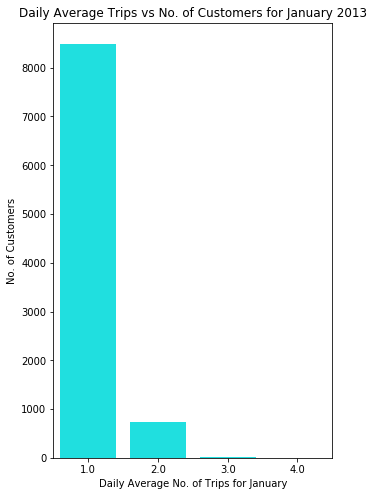

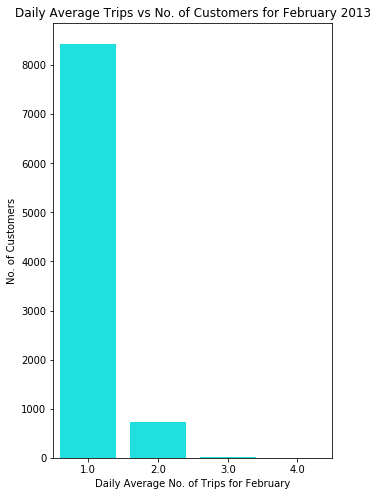

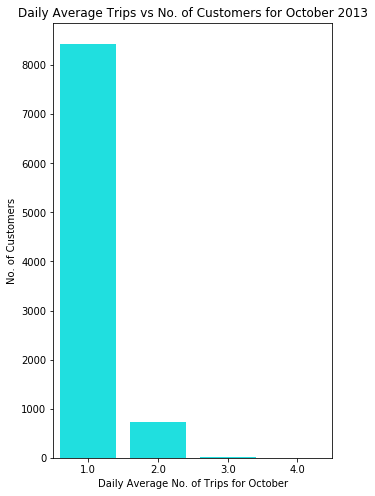

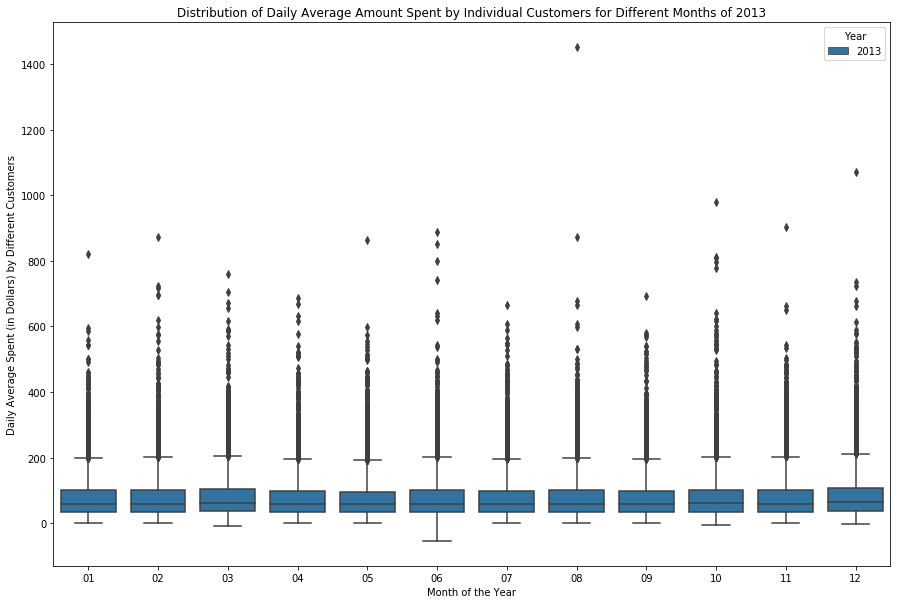

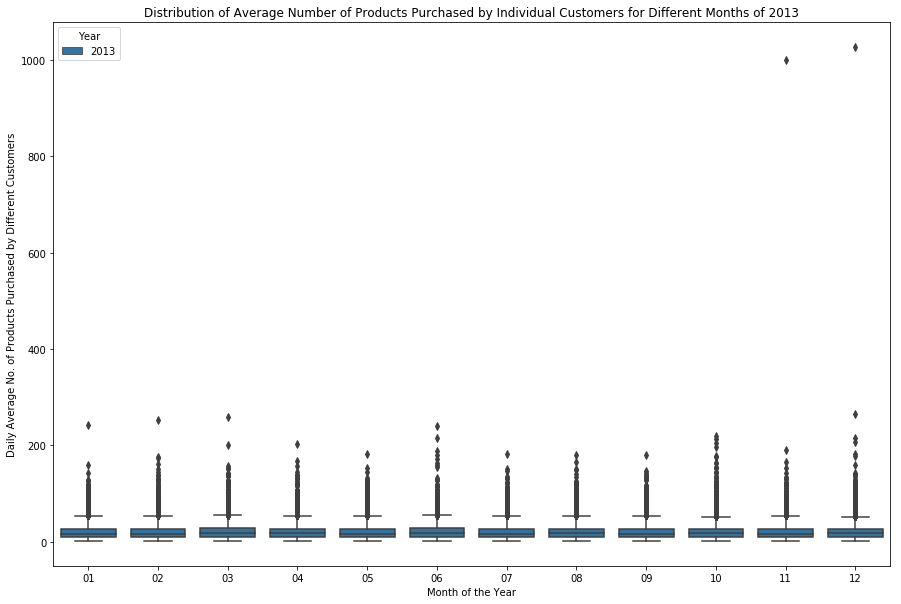

In [93]:
aggregatedJanuaryData = aggregatedMonthlyData[aggregatedMonthlyData["Month"] == "01"]
januaryDailyAverageTrips = aggregatedJanuaryData["Daily_Average_Trips"].value_counts().rename_axis("Daily_Average_Trips").reset_index(name = "No_of_Customers")
plt.figure(figsize = (5, 8))
januaryDailyAverageTripsBarplot = sb.barplot(x = "Daily_Average_Trips", y = "No_of_Customers", data = januaryDailyAverageTrips, color = "cyan")
januaryDailyAverageTripsBarplot.set_title("Daily Average Trips vs No. of Customers for January 2013")
januaryDailyAverageTripsBarplot.set(xlabel = "Daily Average No. of Trips for January", ylabel = "No. of Customers")

aggregatedFebruaryData = aggregatedMonthlyData[aggregatedMonthlyData["Month"] == "02"]
februaryDailyAverageTrips = aggregatedFebruaryData["Daily_Average_Trips"].value_counts().rename_axis("Daily_Average_Trips").reset_index(name = "No_of_Customers")
plt.figure(figsize = (5, 8))
februaryDailyAverageTripsBarplot = sb.barplot(x = "Daily_Average_Trips", y = "No_of_Customers", data = februaryDailyAverageTrips, color = "cyan")
februaryDailyAverageTripsBarplot.set_title("Daily Average Trips vs No. of Customers for February 2013")
februaryDailyAverageTripsBarplot.set(xlabel = "Daily Average No. of Trips for February", ylabel = "No. of Customers")

aggregatedOctoberData = aggregatedMonthlyData[aggregatedMonthlyData["Month"] == "10"]
octoberDailyAverageTrips = aggregatedFebruaryData["Daily_Average_Trips"].value_counts().rename_axis("Daily_Average_Trips").reset_index(name = "No_of_Customers")
plt.figure(figsize = (5, 8))
octoberDailyAverageTripsBarplot = sb.barplot(x = "Daily_Average_Trips", y = "No_of_Customers", data = octoberDailyAverageTrips, color = "cyan")
octoberDailyAverageTripsBarplot.set_title("Daily Average Trips vs No. of Customers for October 2013")
octoberDailyAverageTripsBarplot.set(xlabel = "Daily Average No. of Trips for October", ylabel = "No. of Customers")

plt.figure(figsize = (15, 10))
monthlyAverageSaleAmount = sb.boxplot(x = "Month", y = "Average_Sale_Amount", data = aggregatedMonthlyData, hue = "Year")
monthlyAverageSaleAmount.set_title("Distribution of Daily Average Amount Spent by Individual Customers for Different Months of 2013")
monthlyAverageSaleAmount.set(xlabel = "Month of the Year", ylabel = "Daily Average Spent (in Dollars) by Different Customers")

plt.figure(figsize = (15, 10))
monthlyAverageQuantitySold = sb.boxplot(x = "Month", y = "Average_Quantity_Sold", data = aggregatedMonthlyData, hue = "Year")
monthlyAverageQuantitySold.set_title("Distribution of Average Number of Products Purchased by Individual Customers for Different Months of 2013")
monthlyAverageQuantitySold.set(xlabel = "Month of the Year", ylabel = "Daily Average No. of Products Purchased by Different Customers")

In [39]:
yearDataFile.isna().sum()

Sale_Date                              0
Sale_Time                              0
UniSA_Receipt_No1                      0
Receipt_Line_No                        0
UniSA_Customer_No                 393340
Total_Sale_Amount_InclusiveGST         0
Total_Receipt_Lines                    0
Barcode_Item                         685
Item_Description                       0
Quantity_Sold                          0
Item_Value                             0
Department_Name                   337162
Commodity_Name                    343323
Offer                                  0
Day                                    0
Month                                  0
Year                                   0
dtype: int64

In [101]:
# Aggregate the data over each month to get "Number of Trips in a Month",
# "Average Sale Amount" and "Quantity Sold" to each loyal "UniSA Customer Number".
aggregatedYearlyData = aggregateYearData(yearDataFile)
aggregatedYearlyData.head()

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size of Dataset: (670254, 7)
Size of Dataset: (114694, 6)
Size of Dataset: (8759, 5)


,Year,UniSA_Customer_No,Average_Monthly_Trips,Average_Sale_Amount,Average_Quantity_Sold
0,2014,299827.0000,11.0000,548.8400,162.0000
1,2014,1925237.0000,14.0000,1134.3683,262.0000
2,2014,3004639.0000,4.0000,606.6800,168.0000
3,2014,5225820.0000,4.0000,44.5200,12.0000
4,2014,5714956.0000,6.0000,150.7267,35.0000


[Text(0, 0.5, 'Percentage of Customers'),
 Text(0.5, 0, 'Monthly Average No. of Products Purchased by Different Customers')]

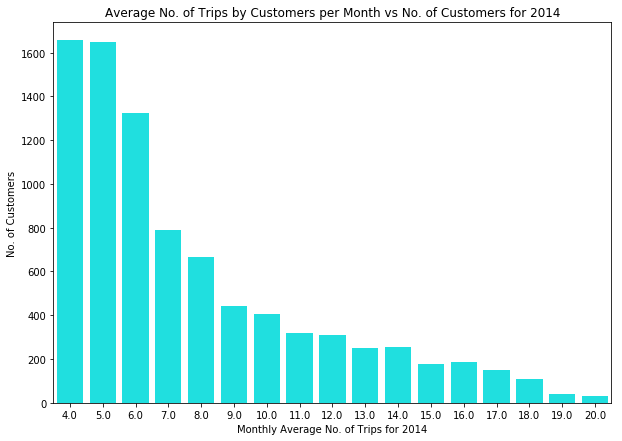

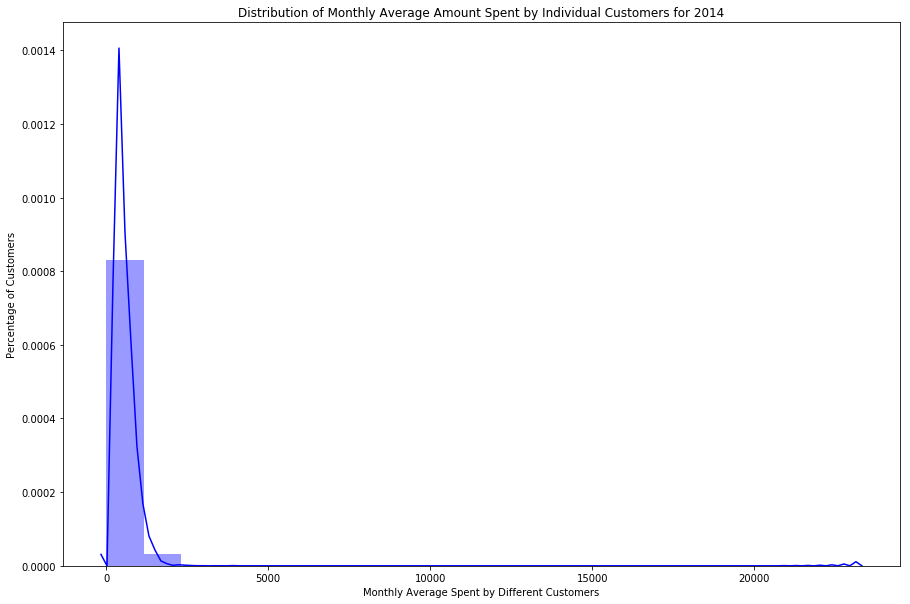

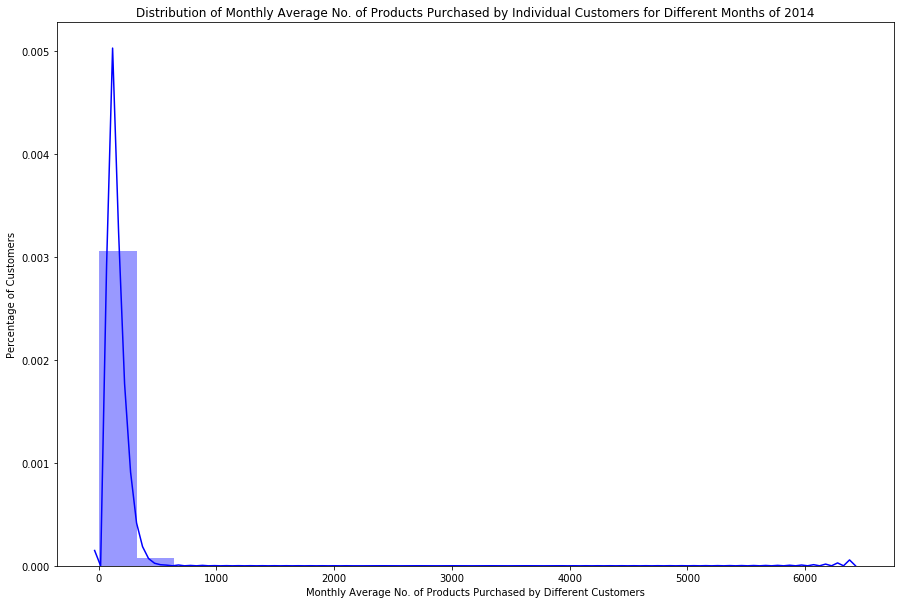

In [102]:
yearMonthlyAverageTrips = aggregatedYearlyData["Average_Monthly_Trips"].value_counts().rename_axis("Average_Monthly_Trips").reset_index(name = "No_of_Customers")
yearMonthlyAverageSaleAmount = aggregatedYearlyData["Average_Sale_Amount"].value_counts().rename_axis("Average_Sale_Amount").reset_index(name = "No_of_Customers")
yearMonthlyAverageSaleAmount["Year"] = "2014"
plt.figure(figsize = (10, 7))
yearMonthlyAverageTripsBarplot = sb.barplot(x = "Average_Monthly_Trips", y = "No_of_Customers", data = yearMonthlyAverageTrips, color = "cyan")
yearMonthlyAverageTripsBarplot.set_title("Average No. of Trips by Customers per Month vs No. of Customers for 2014")
yearMonthlyAverageTripsBarplot.set(xlabel = "Monthly Average No. of Trips for 2014", ylabel = "No. of Customers")

plt.figure(figsize = (15, 10))
yearlyAverageSaleAmount = sb.distplot(aggregatedYearlyData["Average_Sale_Amount"], bins = 20, color = "blue")
yearlyAverageSaleAmount.set_title("Distribution of Monthly Average Amount Spent by Individual Customers for 2014")
yearlyAverageSaleAmount.set(xlabel = "Monthly Average Spent by Different Customers", ylabel = "Percentage of Customers")

plt.figure(figsize = (15, 10))
yearlyAverageQuantitySold = sb.distplot(aggregatedYearlyData["Average_Quantity_Sold"], bins = 20, color = "blue")
yearlyAverageQuantitySold.set_title("Distribution of Monthly Average No. of Products Purchased by Individual Customers for Different Months of 2014")
yearlyAverageQuantitySold.set(xlabel = "Monthly Average No. of Products Purchased by Different Customers", ylabel = "Percentage of Customers")